In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
import pandas as pd
import os

In [3]:
from sklearn.decomposition import PCA
from data_reader import read_banking_data
df, df_codified = read_banking_data()

pca = PCA(n_components=3)
reduced = pca.fit_transform(df_codified.loc[:,df_codified.columns!="y"])
df_reduced = pd.DataFrame(data = reduced, columns = ["x", "y", "z"])
df_reduced["label"] = df.y
df_reduced["pi"] = "pi0"

In [29]:
def pca_experiment(df):
    pca = PCA()
    pca.fit(df)
    print(pca.explained_variance_ratio_)
    print(sum(pca.explained_variance_ratio_[:3]))
    print(sum(pca.explained_variance_ratio_[:2]))
pca_experiment(df_codified.loc[:,df.columns!="y"])

[6.26788004e-01 3.30833615e-01 4.08471400e-02 1.01374092e-03
 1.92314271e-04 1.20238712e-04 6.96673197e-05 4.96416195e-05
 3.82617908e-05 1.80198272e-05 9.08848239e-06 7.24184225e-06
 4.84543109e-06 2.87288460e-06 1.92717561e-06 1.42287924e-06
 1.31112996e-06 2.47969899e-07 2.17159931e-07 1.81502791e-07]
0.998468759079651
0.9576216190451263


In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

def plot_per_label(df):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    yes = df.loc[df.label == "yes"]
    no = df.loc[df.label == "no"]
    ax.scatter3D(yes.x, yes.y, yes.z, alpha=0.3, label = "yes")
    ax.scatter3D(no.x, no.y, no.z, alpha=0.3, label = "no")
    plt.legend()
    plt.show()

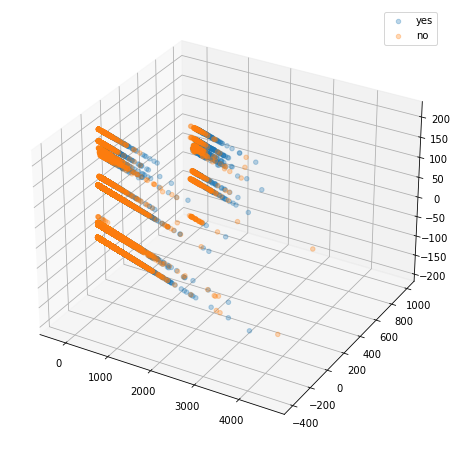

In [6]:
plot_per_label(df_reduced)

In [98]:
yes = df_reduced.loc[df_reduced.label == "yes"]
no = df_reduced.loc[df_reduced.label == "no"]
sample_size = min(yes.shape[0], no.shape[0])
balanced_data =  pd.concat([yes.sample(sample_size), no.sample(sample_size)]).sample(frac=1).reset_index(drop=True)

In [99]:
semibalanced_data = pd.concat([yes, no.sample(int(sample_size*3))]).sample(frac=1).reset_index(drop=True)

In [100]:
semibalanced_data.shape, balanced_data.shape, df_reduced.shape

((18560, 5), (9280, 5), (41188, 5))

In [71]:
yes.shape, no.shape 

((4640, 5), (36548, 5))

In [101]:
from sklearn.mixture import GaussianMixture as GM
from sklearn.cluster import KMeans
import numpy as np

def plot_clusters(train, test, n_clusters, clf="gm", return_clusters = False):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    if clf == "gm":
        clf = GM(n_components = n_clusters, random_state = 0)
    else:
        clf = KMeans(n_clusters = n_clusters, random_state = 0)
    clf.fit(train[["x", "y", "z"]])
#     pred = clf.predict(train[["x", "y", "z"]])
    pred = clf.predict(test[["x", "y", "z"]])
    cluster_data = []
    for cluster in range(n_clusters):
        cluster_points_indices = list(np.where(pred == cluster)[0])
#         cluster_points = train.loc[cluster_points_indices]
        cluster_points = test.loc[cluster_points_indices]
        cluster_data.append(cluster_points)
        ax.scatter3D(cluster_points.x, cluster_points.y, cluster_points.z, alpha=0.3, label = str(cluster+1))
    plt.legend()
    plt.show()
    if return_clusters:
        return cluster_data

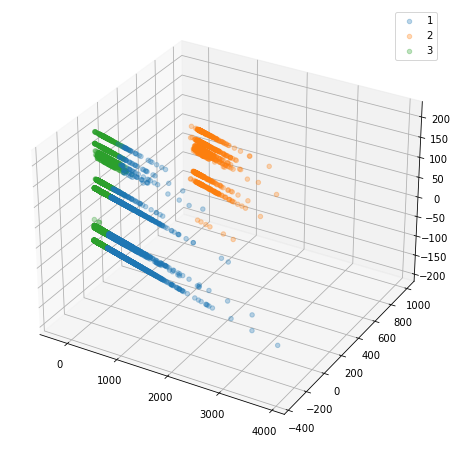

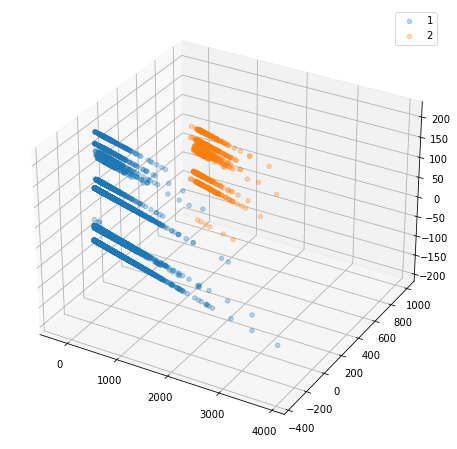

(None, None)

In [11]:
plot_clusters(balanced_data, df_reduced, 3),  plot_clusters(balanced_data,  df_reduced, 2)

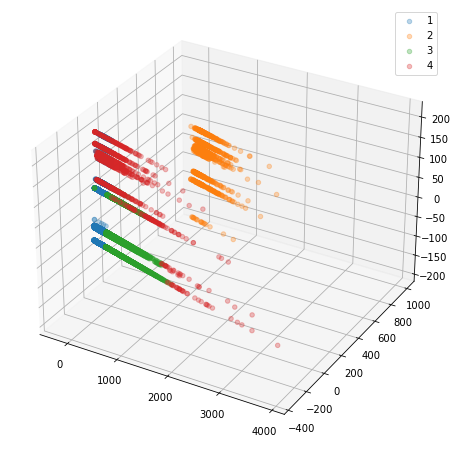

In [102]:
clusters = plot_clusters(balanced_data, semibalanced_data, 4, return_clusters = True)

In [103]:
for c in clusters:
    yes = c.loc[c.label == "yes"]
    no = c.loc[c.label == "no"]
    print(c.shape[0], yes.shape[0], no.shape[0])

11610 1014 10596
1177 967 210
4541 1842 2699
1232 817 415


In [53]:
for c in clusters:
    yes = c.loc[c.label == "yes"]
    no = c.loc[c.label == "no"]
    print(c.shape[0], yes.shape[0], no.shape[0])

4403 933 3470
1040 967 73
1063 902 161
2774 1838 936


In [104]:
## we merge clusters 1 & 2 to create a larger node and skip cluster 3
merged_clusters = [pd.concat([clusters[0], clusters[1], clusters[3]], ignore_index=True), clusters[2]]

In [105]:
for c in merged_clusters:
    yes = c.loc[c.label == "yes"]
    no = c.loc[c.label == "no"]
    print(c.shape[0], yes.shape[0], no.shape[0])

14019 2798 11221
4541 1842 2699


In [109]:
for n in node_data:
    yes = n.loc[n.label == "yes"]
    no = n.loc[n.label == "no"]
    print(n["pi"].values[0], yes.shape[0], no.shape[0])

pi1 696 3510
pi2 619 3587
pi3 658 3548
pi4 801 1224
pi5 765 1258


In [106]:
def create_nodes(df):
    sample_size = int(df.shape[0]/3)
    if sample_size < 2250:
        sample_size = 2250
    if df.shape[0] < sample_size:
        return [df]
    raw_node_data= []
    shuffled_df = df.sample(frac=1)
    no_nodes = int(df.shape[0]/sample_size)
    yes = shuffled_df[shuffled_df.label == "yes"]
    no = shuffled_df[shuffled_df.label == "no"]
    for i in range(no_nodes):
#         node_df = pd.concat([yes.iloc[i*int(yes.shape[0]/no_nodes):(i+1)*int(yes.shape[0]/no_nodes)].copy(),
#                               no.iloc[i*int(no.shape[0]/no_nodes):(i+1)*int(no.shape[0]/no_nodes)].copy()],
#                              ignore_index = True)
        node_df = shuffled_df.iloc[i*sample_size:(i+1) * sample_size].copy()
        raw_node_data.append(node_df)
    return raw_node_data

In [107]:
i=1
raw_node_data = []
for cluster in merged_clusters:
    nodes = create_nodes(cluster)
    for node in nodes:
        node.loc[:, "pi"] = "pi"+ str(i)
        node.reset_index(drop=True, inplace=True)
        i+=1
        raw_node_data.append(node)

In [108]:
from similar import remove_outliers
node_data, models = remove_outliers(raw_node_data, return_models=True)

In [112]:
directory = "//".join([os.getcwd(), "data", "bank-marketing", "reduced"])
pd.concat(raw_node_data).reset_index(drop=True).to_csv(directory + "//raw_node_data.csv")
pd.concat(node_data).reset_index(drop=True).to_csv(directory + "//node_data.csv")

In [4]:
from node import get_node_data
directory = "//".join([os.getcwd(), "data", "bank-marketing", "reduced", "node_data.csv"])
data = pd.read_csv(directory, header =0, index_col = 0)
node_data = get_node_data(data, experiment =False)

In [85]:
from maximum_mean_discrepancy import avg_similarity_disimilarity_MMD as ASDMMD
from prettytable import PrettyTable

def bandwidth_experiment(samples, similar_nodes, other_nodes, bandwidths, kernel):
    print(kernel.upper(), "\n")
    t = PrettyTable(['Bandwidth', 'Similarity MMD', 'Dissimilarity MMD'])
    for bandwidth in bandwidths:
        avg_sim_mmd, avg_dis_mmd, s, d = ASDMMD(samples, similar_nodes, other_nodes, kernel, bandwidth)
        t.add_row([bandwidth, avg_sim_mmd, avg_dis_mmd])
        print(s)
        print(d)
        print()
        
    print(t)
    print()

In [86]:
from maximum_mean_discrepancy import get_tensor_samples
tensor_sample_size = min([df.shape[0] for df in node_data])
tensor_samples = get_tensor_samples(node_data, sample_size=tensor_sample_size)

In [110]:
import numpy as np
similar_nodes = ["pi4", "pi5"]
other_nodes = ["pi" +str(i+1) for i in range(5) if "pi" +str(i+1) not in similar_nodes]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.001, 0.01, 5), "linear")

LINEAR 

+----------------+----------------------+
|     Nodes      |     Similar MMD      |
+----------------+----------------------+
| ('pi4', 'pi5') | 0.15579986572265625  |
| ('pi1', 'pi2') | 0.026214122772216797 |
| ('pi1', 'pi3') | 0.08233165740966797  |
| ('pi2', 'pi3') | 0.06278610229492188  |
+----------------+----------------------+
+----------------+--------------------+
|     Nodes      |   Dissimilar MMD   |
+----------------+--------------------+
| ('pi1', 'pi4') |   197.908203125    |
| ('pi1', 'pi5') | 196.69046020507812 |
| ('pi2', 'pi4') | 195.61114501953125 |
| ('pi2', 'pi5') | 194.39874267578125 |
| ('pi3', 'pi4') | 199.4922637939453  |
| ('pi3', 'pi5') | 198.28866577148438 |
+----------------+--------------------+

+----------------+---------------------+
|     Nodes      |     Similar MMD     |
+----------------+---------------------+
| ('pi4', 'pi5') |  0.506439208984375  |
| ('pi1', 'pi2') | 0.08519363403320312 |
| ('pi1', 'pi3') |  0.2675800323486328 |
| ('pi2'

In [111]:
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(10, 100, 5), "rbf")

RBF 

+----------------+-----------------------+
|     Nodes      |      Similar MMD      |
+----------------+-----------------------+
| ('pi4', 'pi5') | 0.0011353716254234314 |
| ('pi1', 'pi2') | 0.0010031531564891338 |
| ('pi1', 'pi3') | 0.0010990751907229424 |
| ('pi2', 'pi3') | 0.0010216222144663334 |
+----------------+-----------------------+
+----------------+----------------------+
|     Nodes      |    Dissimilar MMD    |
+----------------+----------------------+
| ('pi1', 'pi4') | 0.011084605008363724 |
| ('pi1', 'pi5') | 0.011113938875496387 |
| ('pi2', 'pi4') |  0.0109648946672678  |
| ('pi2', 'pi5') | 0.01099967397749424  |
| ('pi3', 'pi4') | 0.01165722869336605  |
| ('pi3', 'pi5') | 0.011677812784910202 |
+----------------+----------------------+

+----------------+-----------------------+
|     Nodes      |      Similar MMD      |
+----------------+-----------------------+
| ('pi4', 'pi5') |  0.001104169525206089 |
| ('pi1', 'pi2') | 0.0009034024551510811 |
| ('pi1', 'pi3

In [ ]:
"linear", 2
"rbf", 3250